<a href="https://colab.research.google.com/github/colaquafina/Roller-King/blob/main/Roller_King.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Roller King的project代码

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
from glob import glob

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit,cross_validate

In [6]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

if not os.path.exists('Roller-King'):
    !git clone https://github.com/colaquafina/Roller-King.git

Cloning into 'Roller-King'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 67 (delta 31), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [7]:
with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')
labels.shape

(4, 1750)

# clustering

In [12]:
from sklearn import cluster,manifold

## 先看看数据在二维平面长什么样

In [28]:
#tsne = manifold.TSNE(random_state = 12345,n_jobs = -1,verbose = 1) #tsne是一种数据降维和可视化的方法，它可以将高维的数据投影到二维
#X_visual = tsne.fit_transform(dat['responses'])  #kl=2.0

#########
tsne=manifold.TSNE(perplexity=60,learning_rate=200,random_state = 12345,n_jobs = -1,verbose = 1)
X_visual = tsne.fit_transform(dat['responses'])  #kl=1.90

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 1750 samples in 1.091s...
[t-SNE] Computed neighbors for 1750 samples in 24.564s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1750
[t-SNE] Computed conditional probabilities for sample 1750 / 1750
[t-SNE] Mean sigma: 23.558547
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.695450
[t-SNE] KL divergence after 1000 iterations: 1.981533


In [29]:
#print(X_visual.shape),tsne.embedding_.shape

(1750, 2)


(None, (1750, 2))

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


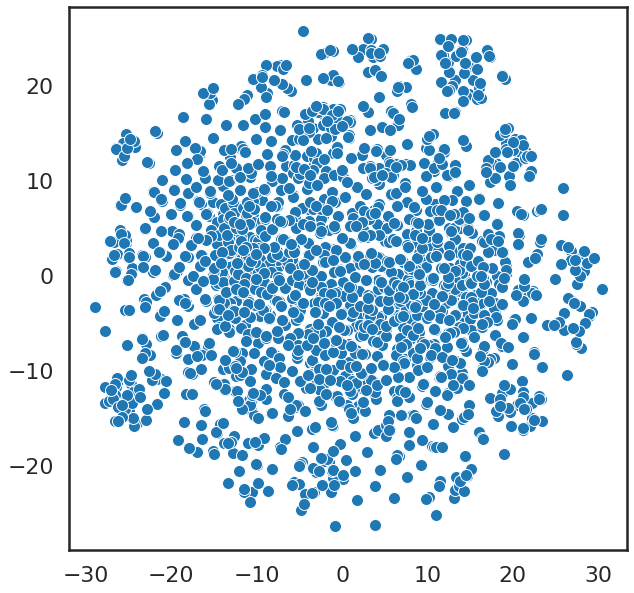

In [32]:
fig,ax = plt.subplots(figsize = (10,10))
ax = sns.scatterplot(X_visual[:,0],X_visual[:,1])

## 在这个基础上，我们拟合一个clustering的函数，这不需要label

In [58]:
kmeans = cluster.KMeans(n_clusters = 2, random_state=12345,n_jobs = -1, verbose = 1)
kmeans.fit(dat['responses'])  #s=74


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=12345, tol=0.0001, verbose=1)

In [59]:
kmeans_labels = kmeans.labels_

In [60]:
#from sklearn import metrics
#metrics.calinski_harabaz_score(dat['responses'], kmeans.labels_)  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


74.0767532206123

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


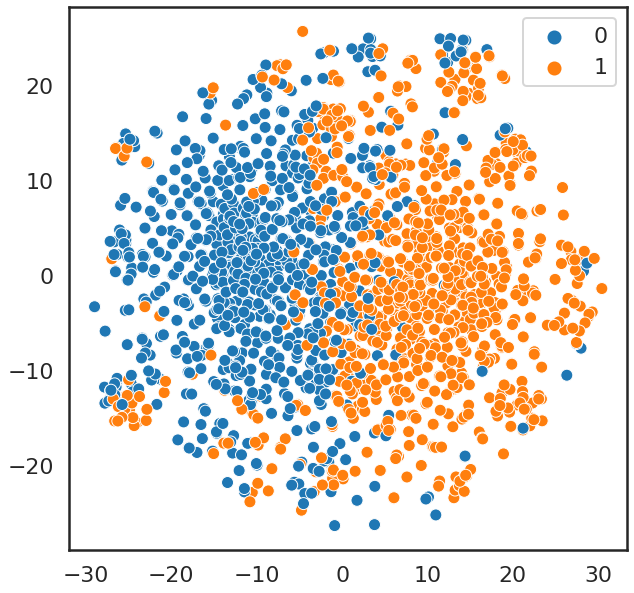

In [61]:
fig,ax = plt.subplots(figsize = (10,10))
ax = sns.scatterplot(X_visual[:,0],X_visual[:,1],hue = kmeans_labels)

# Decoding workflow

In [8]:
manual_labels = np.concatenate([np.load(item) for item in glob('Roller-King/judge_*.npy')])

In [26]:
?np.unique

In [9]:
unique_roi_index = np.unique(dat['roi']) #找到不重复的元素的个数
unique_roi_names = ['V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'Laterial occipital']
for idx,name in zip(unique_roi_index,unique_roi_names):
    print(name,np.sum(dat['roi'] == idx))

V1 1294
V2 2083
V3 1790
V3A 484
V3B 314
V4 1535
Laterial occipital 928


In [25]:
print(unique_roi_index)
print(dat['roi'])

[1 2 3 4 5 6 7]
[3 3 3 ... 3 3 6]


In [36]:
def decoding_pipeline(BOLD_signal_voxels,manual_labels,
                      n_splits = 100,
                      ):
    feature_scaler = StandardScaler()
    model = linear_model.LogisticRegression(class_weight = 'balanced',random_state = 12345)
    pipeline = make_pipeline(feature_scaler,
                             model) #什么意思？ # 这是所谓的pipeline，在一个pipeline里有步骤，第一步对数据进行归中，第二部才拟合一个logisticregression
    cv = StratifiedShuffleSplit(n_splits = n_splits,test_size = 0.2, random_state = 12345)
    decoding_results = cross_validate(pipeline,
                                      BOLD_signal_voxels,
                                      manual_labels,
                                      groups = None,
                                      scoring = 'roc_auc',#什么意思？ # https://en.wikipedia.org/wiki/Receiver_operating_characteristic
                                      cv = cv,
                                      n_jobs = -1,
                                      return_estimator = True,
                                      verbose = 1,
                                      )
    return decoding_results#得到的是什么？ 得到一dictionary的变量，里面包含拟合的方程和每一次cross-validation的测试结果

In [37]:
results = dict()
for roi_name,idx_voxel in zip(unique_roi_names,unique_roi_index):#zip是要把两个参数从0开始一一对应组成一个个含有两个元素的元组
    voxel_selected = dat['responses'][:manual_labels.shape[0],dat['roi'] == idx_voxel]
    results[roi_name] = decoding_pipeline(voxel_selected,manual_labels,n_splits = 100) 
    #这个的意思是我们分别提取了不同visual field中voxel然后训练模型，输入是voxel，输出是label

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Don

In [38]:
df_plot = dict(roi_name = [],
               roc_auc = [],
               )
for roi_name,res in results.items():
    for score in res['test_score']:
        df_plot['roi_name'].append(roi_name)
        df_plot['roc_auc'].append(score)
df_plot = pd.DataFrame(df_plot)

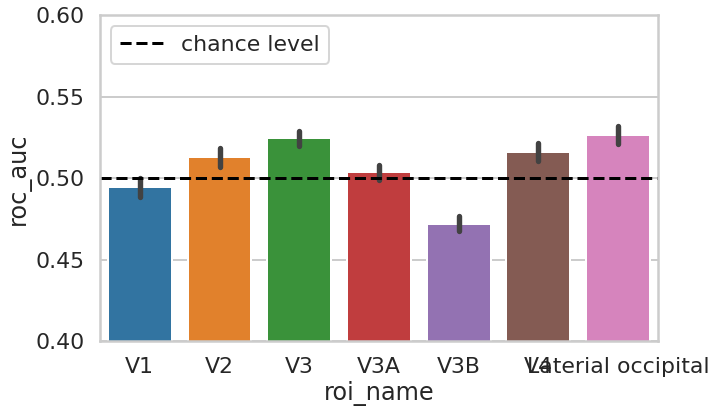

In [39]:
fig,ax = plt.subplots(figsize = (10,6))
ax = sns.barplot(x = 'roi_name',
                 y = 'roc_auc',
                 data = df_plot,
                 ax = ax,
                 )
ax.axhline(0.5, linestyle = '--',color = 'black',label = 'chance level')
ax.set(ylim = (0.4,0.6))
ax.legend(loc = 'upper left')

In [30]:
from scipy.spatial import distance

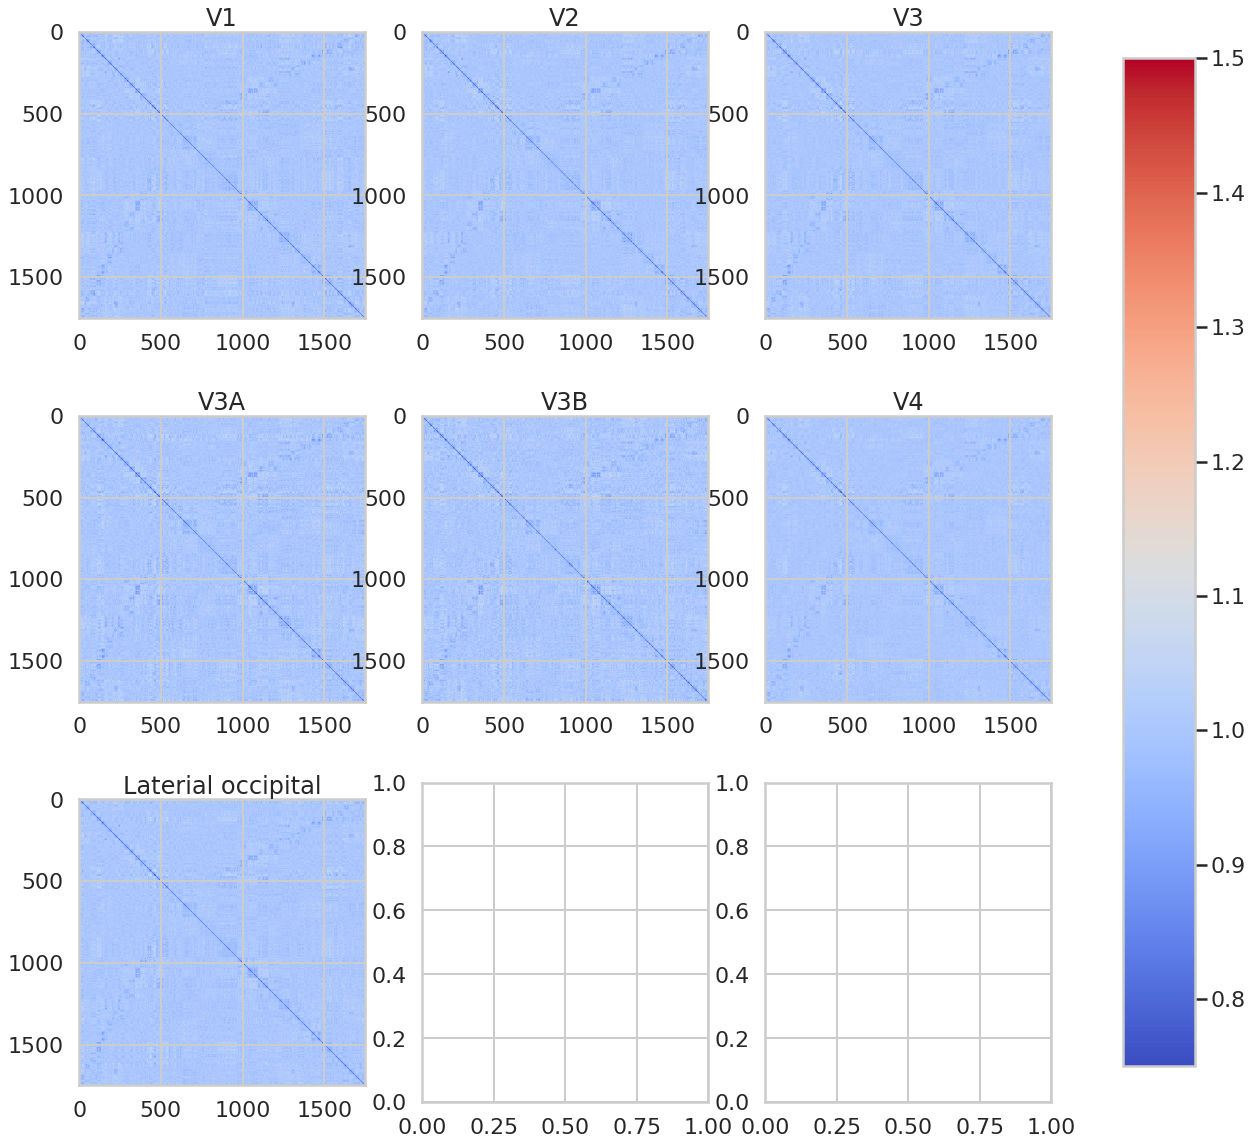

In [31]:
fig,axes = plt.subplots(figsize = (20,20,),
                        nrows = 3,
                        ncols = 3,
                        )
for roi_name,idx_voxel,ax in zip(unique_roi_names,unique_roi_index,axes.flatten()):
    voxel_selected = dat['responses'][:manual_labels.shape[0],dat['roi'] == idx_voxel]
    idx_sort = np.argsort(manual_labels)
    X = voxel_selected[idx_sort]
    y = manual_labels[idx_sort]
    RDM = distance.squareform(distance.pdist(X,metric = 'correlation'))
    im = ax.imshow(RDM,cmap = plt.cm.coolwarm,vmin = .75,vmax = 1.5)
    ax.set(title = roi_name)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# **Decoding ends**

In [62]:
dat["judge"]=np.array([])  #加多一个judge的key作为分类

In [63]:
for saving_name, (key,val) in zip(['stimuli.npy',
                                   'stimuli_test.npy',
                                   'responses.npy',
                                   'responses_test.npy',
                                   'roi.npy',
                                   'roi_names.npy','judge.npy'],
                                  dat.items()):
    print(key,val.shape)
    np.save(saving_name,val)

stimuli (1750, 128, 128)
stimuli_test (120, 128, 128)
responses (1750, 8428)
responses_test (120, 8428)
roi (8428,)
roi_names (8,)
judge (0,)


In [ ]:
dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

{'LatOcc': 928,
 'Other': 0,
 'V1': 1294,
 'V2': 2083,
 'V3': 1790,
 'V3A': 484,
 'V3B': 314,
 'V4': 1535}

In [ ]:
dat.keys()

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names', 'judge'])

In [ ]:
from collections import Counter
for row in labels:
    print(Counter(row))

Counter({'artifact': 812, 'animal': 589, 'geological formation': 192, 'fruit': 77, 'entity': 72, 'fungus': 5, 'person': 2, 'plant': 1})
Counter({'vertebrate': 560, 'instrumentality': 352, 'structure': 277, 'covering': 154, 'natural elevation': 61, 'shore': 60, 'natural depression': 51, 'solid': 48, 'edible fruit': 39, 'invertebrate': 33, 'substance': 27, 'seed': 21, 'fabric': 10, 'spring': 7, 'cliff': 7, 'surface': 6, 'commodity': 6, 'decoration': 4, 'ear': 4, 'acorn': 4, 'hip': 3, 'visual signal': 3, 'round shape': 2, 'hen-of-the-woods': 2, 'creation': 2, 'explorer': 2, 'earthstar': 2, 'sheet': 1, 'gyromitra': 1, 'vascular plant': 1})
Counter({'mammal': 367, 'clothing': 98, 'container': 89, 'reptile': 86, 'device': 83, 'building': 76, 'food': 76, 'bird': 60, 'valley': 53, 'furnishing': 50, 'protective covering': 47, 'obstruction': 45, 'lakeside': 44, 'conveyance': 44, 'implement': 38, 'mountain': 37, 'equipment': 32, 'establishment': 31, 'aquatic vertebrate': 30, 'seashore': 20, 'arth

In [66]:
import time

In [64]:
dat["judge"]=np.array([]) 

这个好像已经可以根据图片取标注了，然后标注到一半的时候如果你不想标了你就把最后一个值输入进去之后就可以停止了，下一次会再输入的话就是从你停止的哪里开始

In [70]:
'''
for image in dat["stimuli"][dat["judge"].size:1750]:
    fig,ax = plt.subplots()
    ax.imshow(image,cmap='gray')
    plt.show()
    time.sleep(0.5)
    plt.close(fig)
    x = input()    
    if(x=='2'):
      break
    else:
      a=np.array([x])
      dat["judge"]=np.insert(dat["judge"],0,values=a,axis=0)
   ''' 

'\nfor image in dat["stimuli"][dat["judge"].size:1750]:\n    fig,ax = plt.subplots()\n    ax.imshow(image,cmap=\'gray\')\n    plt.show()\n    time.sleep(0.5)\n    plt.close(fig)\n    x = input()    \n    if(x==\'2\'):\n      break\n    else:\n      a=np.array([x])\n      dat["judge"]=np.insert(dat["judge"],0,values=a,axis=0)\n   '

In [68]:
print(dat["judge"])

[]


In [69]:
'''
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1,:]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()
'''

'\nf, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)\nfor ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1,:]):\n  ax.imshow(im, cmap="gray")\n  ax.set_title(lbl)\nf.tight_layout()\n'

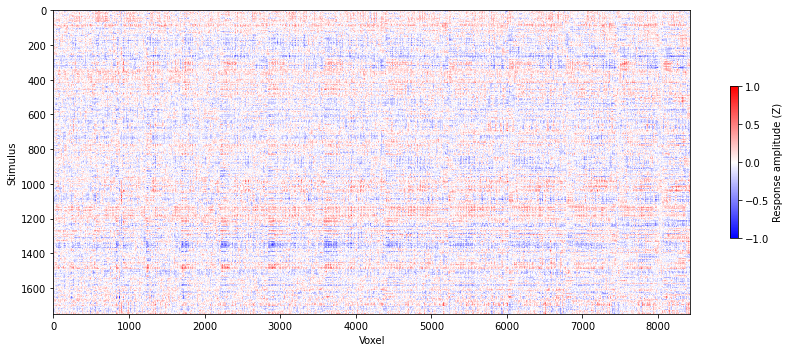

In [ ]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

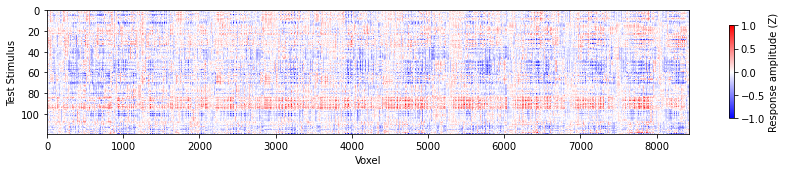

In [ ]:
f, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
f.tight_layout()